In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Graph, MarkovChain,
                        updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import numpy as np

In [2]:
g = Graph.from_file("./NY/NY.shp")

NUM_DISTRICTS = 26

/Users/y.solomon/opt/anaconda3/envs/gerry/lib/python3.12/site-packages/gerrychain/graph/graph.py:274: UserWarning: Found islands (degree-0 nodes). Indices of islands: {10308}
  warnings.warn(
/Users/y.solomon/opt/anaconda3/envs/gerry/lib/python3.12/site-packages/gerrychain/graph/graph.py:179: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [3]:
elections = [
    Election("SEN18", {"Democratic": "G18SEND", "Republican": "G18SENR"}),
    Election("GOV18", {"Democratic": "G18GOVD", "Republican": "G18GOVR"}),
    Election("COM18", {"Democratic": "G18COMD", "Republican": "G18COMR"}),
    Election("ATG18", {"Democratic": "G18ATGD", "Republican": "G18ATGR"}),
]

my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [4]:
initial_partition = GeographicPartition(g, assignment= "CD", updaters=my_updaters)

In [5]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
print(ideal_population)

776971.1153846154


In [6]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [7]:
chain = MarkovChain(
      proposal=proposal,
      constraints=[
            pop_constraint,
            compactness_bound,
      ],
      accept=accept.always_accept,
      initial_state=initial_partition,
      total_steps=20000
      )

In [8]:
gov_buckets = [[] for _ in range(NUM_DISTRICTS)] # make one bucket per district
sen_buckets = [[] for _ in range(NUM_DISTRICTS)] # make one bucket per district
atg_buckets = [[] for _ in range(NUM_DISTRICTS)] # make one bucket per district
com_buckets = [[] for _ in range(NUM_DISTRICTS)] # make one bucket per district

In [9]:
for state in chain:
  gov_dem_percents = sorted(state["GOV18"].percents("Democratic"))
  sen_dem_percents = sorted(state["SEN18"].percents("Democratic"))
  atg_dem_percents = sorted(state["ATG18"].percents("Democratic"))
  com_dem_percents = sorted(state["COM18"].percents("Democratic"))
  
  for i in range(NUM_DISTRICTS):
    gov_buckets[i].append(gov_dem_percents[i])
    sen_buckets[i].append(sen_dem_percents[i])
    atg_buckets[i].append(atg_dem_percents[i])
    com_buckets[i].append(com_dem_percents[i])

[]

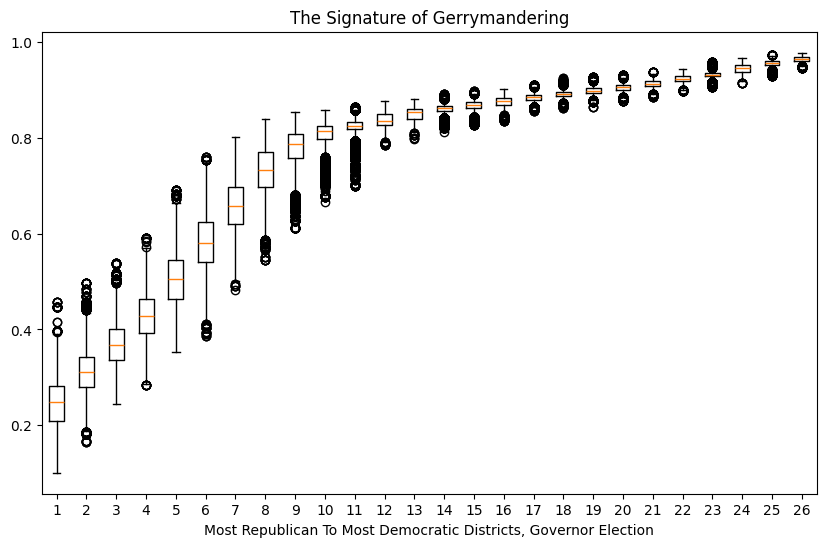

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(gov_buckets, vert=True)

# Set the title and labels
ax.set_title('The Signature of Gerrymandering')
ax.set_xlabel('Most Republican To Most Democratic Districts, Governor Election')

plt.savefig('./box_plots/GOV18_box_plot.png')

plt.plot()

[]

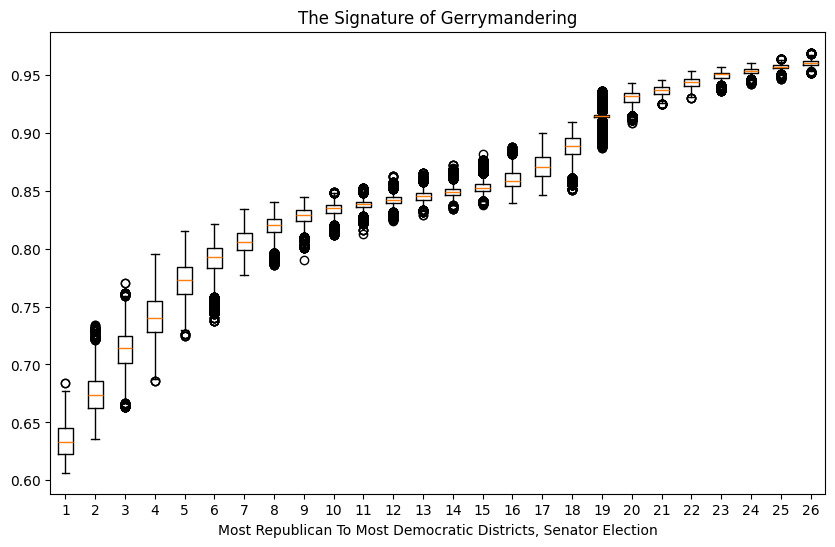

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(sen_buckets, vert=True)

# Set the title and labels
ax.set_title('The Signature of Gerrymandering')
ax.set_xlabel('Most Republican To Most Democratic Districts, Senator Election')

plt.savefig('./box_plots/SEN18_box_plot.png')

plt.plot()

[]

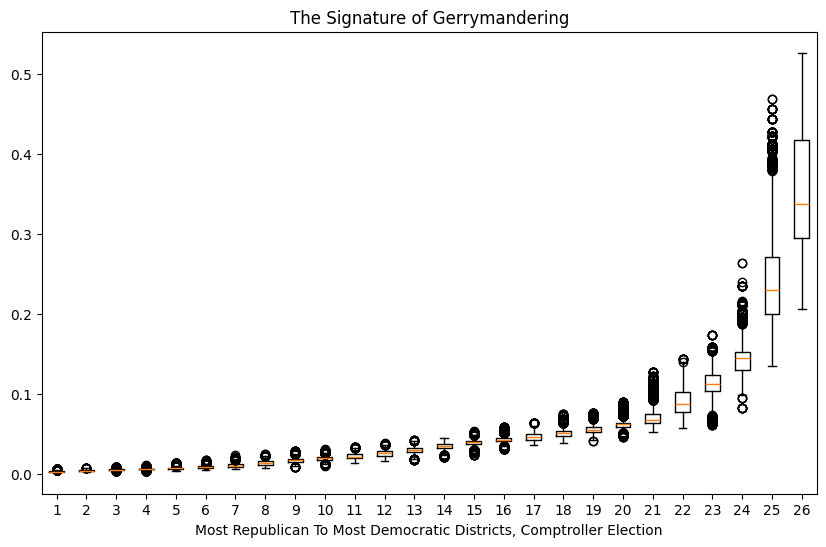

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(com_buckets, vert=True)

# Set the title and labels
ax.set_title('The Signature of Gerrymandering')
ax.set_xlabel('Most Republican To Most Democratic Districts, Comptroller Election')

plt.savefig('./box_plots/COM18_box_plot.png')

plt.plot()

[]

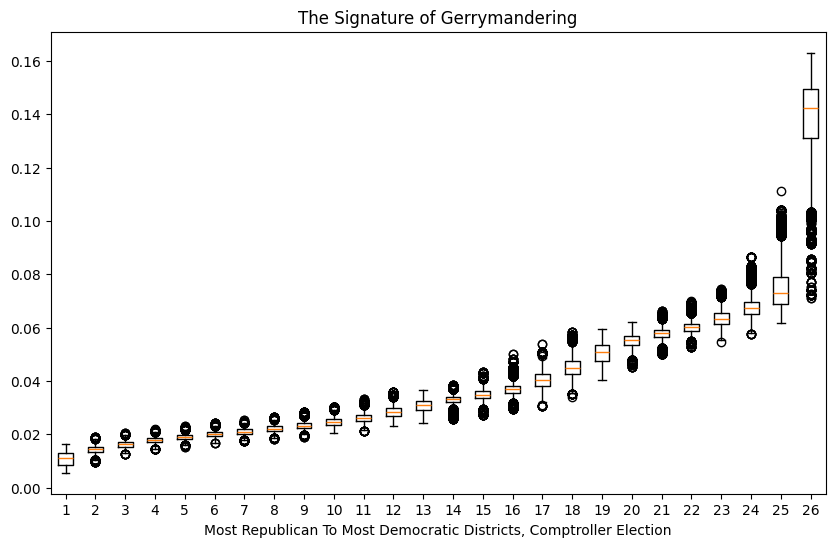

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(atg_buckets, vert=True)

# Set the title and labels
ax.set_title('The Signature of Gerrymandering')
ax.set_xlabel('Most Republican To Most Democratic Districts, Comptroller Election')

plt.savefig('./box_plots/ATG18_box_plot.png')

plt.plot()